In [22]:
# Install necessary libraries
!pip install pandas scikit-learn matplotlib seaborn torch shap

# CNN-GRU Hybrid

CNN-GRU hybrid is excellent. The CNN extracts spatial patterns (spikes in HR), and the GRU (Gated Recurrent Unit) tracks how those patterns evolve over time. 

It is faster and more "mobile-friendly" than a standard LSTM.
Adapted for mobile use

## Traning

In [1]:
# ==========================================
# 0. IMPORTS
# ==========================================
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.mobile_optimizer import optimize_for_mobile

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os
import warnings

In [2]:
# ==========================================
# 1. SETTINGS & FEATURES
# ==========================================
# Update these paths to match your local folders
TRAIN_PATH = 'data/train-wearable.csv' 
TEST_PATH = 'data/test-wearable.csv'
MODEL_EXPORT_PATH = 'models/wearable/stress_model.pt'

WINDOW_SIZE = 30
BATCH_SIZE = 64
EPOCHS = 60 # Increased epochs to allow class weights to take effect
LEARNING_RATE = 1e-3

# The "Big 5" real-time features
FEATURES = ['HR', 'MEAN_RR', 'SDRR', 'RMSSD', 'pNN50']
INPUT_DIM = len(FEATURES)
LABEL_MAP = {'no stress': 0, 'interruption': 1, 'time pressure': 2}

In [3]:
# ==========================================
# 2. DATA PREPARATION
# ==========================================
class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

def create_windows(df, scaler=None, is_train=True):
    # Map labels
    df['label'] = df['condition'].map(LABEL_MAP)
    
    # Scale features
    if is_train:
        scaler = StandardScaler()
        df[FEATURES] = scaler.fit_transform(df[FEATURES])
    else:
        df[FEATURES] = scaler.transform(df[FEATURES])

    data = df[FEATURES].values
    labels = df['label'].values

    X_list, y_list = [], []
    for i in range(len(df) - WINDOW_SIZE):
        X_list.append(data[i : i + WINDOW_SIZE])
        y_list.append(labels[i + WINDOW_SIZE - 1])
    
    return np.array(X_list), np.array(y_list), scaler

print(">>> Processing Data...")
df_train_full = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

X_train_all, y_train_all, fitted_scaler = create_windows(df_train_full, is_train=True)
X_test, y_test, _ = create_windows(df_test, scaler=fitted_scaler, is_train=False)

# Validation split
split = int(0.8 * len(X_train_all))
train_loader = DataLoader(StressDataset(X_train_all[:split], y_train_all[:split]), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(StressDataset(X_train_all[split:], y_train_all[split:]), batch_size=BATCH_SIZE)
test_loader = DataLoader(StressDataset(X_test, y_test), batch_size=BATCH_SIZE)

# Calculate Class Weights to force model to learn "Time Pressure"
# This fixes the "Everything is No Stress" bug
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_all), 
    y=y_train_all
)
class_weights = torch.tensor(weights, dtype=torch.float)
print(f"Calculated Class Weights: {weights}")

>>> Processing Data...
Calculated Class Weights: [0.61523172 1.17067874 1.92163261]


In [4]:
# ==========================================
# 3. CNN-GRU HYBRID MODEL
# ==========================================
class StressModel(nn.Module):
    def __init__(self, input_dim):
        super(StressModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.gru = nn.GRU(64, 32, num_layers=2, batch_first=True, dropout=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(32, 16), 
            nn.ReLU(), 
            nn.Linear(16, 3)
        )

    def forward(self, x):
        # x: [Batch, Window, Feat] -> transpose for Conv1d
        x = x.transpose(1, 2) 
        x = self.conv(x)
        x = x.transpose(1, 2) 
        _, h_n = self.gru(x)
        return self.classifier(h_n[-1])

In [32]:
# ==========================================
# 4. TRAINING
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StressModel(INPUT_DIM).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# Pass class weights to the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

history = {'train_loss': [], 'val_f1': []}

print(f">>> Training on {device}...")
for epoch in range(EPOCHS):
    model.train()
    t_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    
    # Validation
    model.eval()
    vp, vt = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb.to(device))
            vp.extend(out.argmax(1).cpu().numpy())
            vt.extend(yb.numpy())
    
    report = classification_report(vt, vp, output_dict=True, zero_division=0)
    f1 = report['macro avg']['f1-score']
    history['train_loss'].append(t_loss/len(train_loader))
    history['val_f1'].append(f1)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {t_loss/len(train_loader):.4f} | Val F1: {f1:.4f}")

>>> Training on cuda...
Epoch 05 | Loss: 0.2917 | Val F1: 0.9004
Epoch 10 | Loss: 0.2127 | Val F1: 0.9289
Epoch 15 | Loss: 0.1835 | Val F1: 0.9309
Epoch 20 | Loss: 0.1660 | Val F1: 0.9524
Epoch 25 | Loss: 0.1539 | Val F1: 0.9460
Epoch 30 | Loss: 0.1470 | Val F1: 0.9610
Epoch 35 | Loss: 0.1408 | Val F1: 0.9606
Epoch 40 | Loss: 0.1346 | Val F1: 0.9621
Epoch 45 | Loss: 0.1307 | Val F1: 0.9602
Epoch 50 | Loss: 0.1278 | Val F1: 0.9666
Epoch 55 | Loss: 0.1235 | Val F1: 0.9515
Epoch 60 | Loss: 0.1208 | Val F1: 0.9663


## Save and Export

In [36]:
# ==========================================
# 5. SAVE ORIGINAL MODEL
# ==========================================
torch.save(model.state_dict(), 'models/model10_cnn_gru.pt')
print(f"\n>>> Save Successful!")


>>> Save Successful!


In [37]:
# ==========================================
# 6. WEARABLE EXPORT
# ==========================================
model.eval().to('cpu')
scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(MODEL_EXPORT_PATH)
print(f"\n>>> Export Successful! {MODEL_EXPORT_PATH} ready.")


>>> Export Successful! models/wearable/stress_model.pt ready.


## Simple Performance Test


>>> Running Final Test on test.csv...


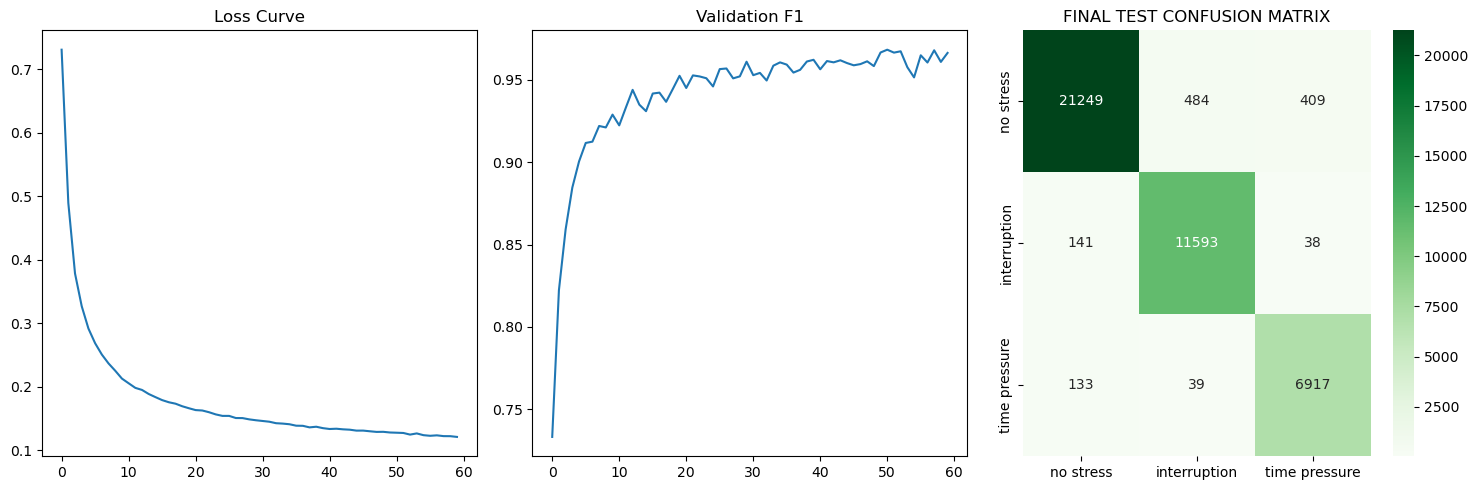


--- FINAL TEST REPORT ---
               precision    recall  f1-score   support

    no stress       0.99      0.96      0.97     22142
 interruption       0.96      0.98      0.97     11772
time pressure       0.94      0.98      0.96      7089

     accuracy                           0.97     41003
    macro avg       0.96      0.97      0.97     41003
 weighted avg       0.97      0.97      0.97     41003



In [34]:
# ==========================================
# 8. FINAL TEST EVALUATION
# ==========================================
print("\n>>> Running Final Test on test.csv...")
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb.to(device))
        test_preds.extend(out.argmax(1).cpu().numpy())
        test_targets.extend(yb.numpy())

# Results Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.plot(history['train_loss']); plt.title("Loss Curve")
plt.subplot(1, 3, 2); plt.plot(history['val_f1']); plt.title("Validation F1")
plt.subplot(1, 3, 3)
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.title("FINAL TEST CONFUSION MATRIX")
plt.tight_layout()
plt.show()

print("\n--- FINAL TEST REPORT ---")
print(classification_report(test_targets, test_preds, target_names=LABEL_MAP.keys()))

## Reliability Performance Test

In [8]:
# Initialize and Load
FEATURES = ['HR', 'MEAN_RR', 'SDRR', 'RMSSD', 'pNN50']
CLASSES = ['No Stress', 'Interrupted', 'Time Pressure']
WINDOW_SIZE = 30
MODEL_PATH = 'models/model9_cnn_gru.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StressModel(input_dim=len(FEATURES)).to(device)

try:
    # This loads the 'normal' state_dict you saved during training
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(f">>> Model successfully loaded from {MODEL_PATH}")
except Exception as e:
    print(f">>> Error loading model: {e}")

>>> Model successfully loaded from models/model9_cnn_gru.pt



>>> Generating Reliability Analysis...


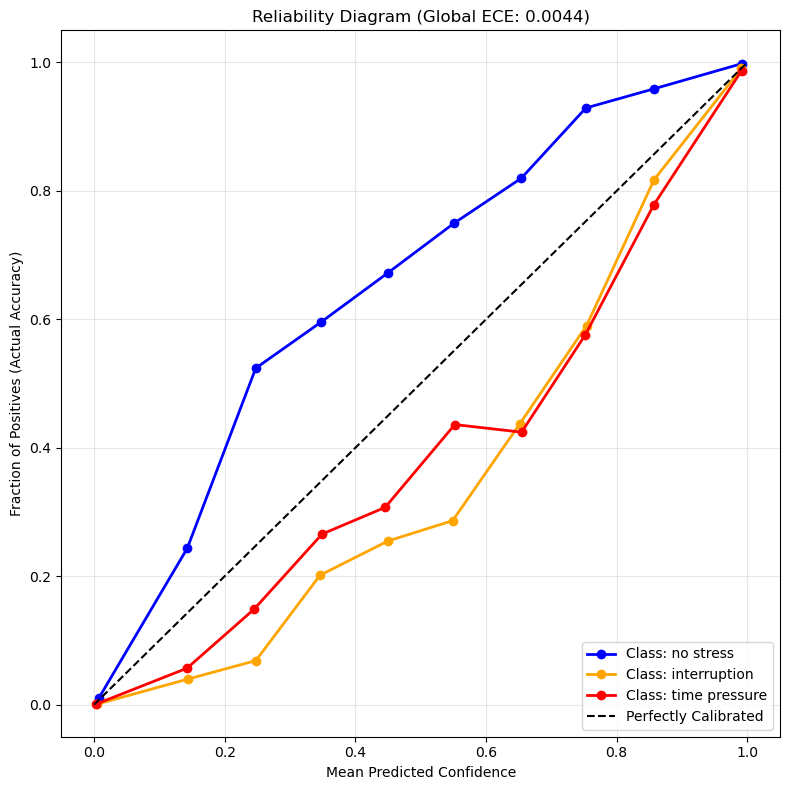

>>> Reliability analysis complete. ECE: 0.0044
>>> Diagram saved as 'reliability_diagram.png'


In [9]:
# ==========================================
# 9. RELIABILITY DIAGRAM & CALIBRATION
# ==========================================
print("\n>>> Generating Reliability Analysis...")
model.eval()
all_probs = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb.to(device))
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_targets.append(yb.numpy())

all_probs = np.vstack(all_probs)
all_targets = np.concatenate(all_targets)

# Create the plot for all 3 classes
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = ['blue', 'orange', 'red']
n_bins = 10

for i, class_name in enumerate(LABEL_MAP.keys()):
    # Get binary targets for this specific class (One-vs-Rest)
    y_true_class = (all_targets == i).astype(int)
    y_prob_class = all_probs[:, i]
    
    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_true_class, y_prob_class, n_bins=n_bins)
    
    ax.plot(prob_pred, prob_true, marker='o', linewidth=2, 
            label=f'Class: {class_name}', color=colors[i])

# Plot the "Perfectly Calibrated" diagonal
ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')

# Expected Calibration Error (ECE) calculation
def get_ece(probs, targets, bins=10):
    bin_boundaries = np.linspace(0, 1, bins + 1)
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == targets)
    ece = 0
    for i in range(bins):
        in_bin = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            acc_in_bin = np.mean(accuracies[in_bin])
            conf_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(acc_in_bin - conf_in_bin) * prop_in_bin
    return ece

ece_val = get_ece(all_probs, all_targets)

ax.set_xlabel('Mean Predicted Confidence')
ax.set_ylabel('Fraction of Positives (Actual Accuracy)')
ax.set_title(f'Reliability Diagram (Global ECE: {ece_val:.4f})')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reliability_diagram.png')
plt.show()

print(f">>> Reliability analysis complete. ECE: {ece_val:.4f}")
print(">>> Diagram saved as 'reliability_diagram.png'")

## SHAP Peformance Test

In [18]:
# Suppress version/RNG warnings
warnings.filterwarnings("ignore")

class StressModel(nn.Module):
    def __init__(self, input_dim):
        super(StressModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.gru = nn.GRU(64, 32, num_layers=2, batch_first=True, dropout=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(32, 16), 
            nn.ReLU(), 
            nn.Linear(16, 3)
        )

    def forward(self, x):
        # x: [Batch, Time, Feat] -> Conv expects [Batch, Feat, Time]
        x = x.transpose(1, 2) 
        self.gru.flatten_parameters()
        x = self.conv(x)
        x = x.transpose(1, 2) 
        _, h_n = self.gru(x)
        # We explain the final classification output [Batch, 3]
        return self.classifier(h_n[-1])

In [19]:
# --- Setup ---
FEATURES = ['HR', 'MEAN_RR', 'SDRR', 'RMSSD', 'pNN50']
CLASSES = ['No Stress', 'Interrupted', 'Time Pressure']
WINDOW_SIZE = 30
MODEL_PATH = 'models/model-final_cnn_gru.pt'

# Prepare Data
df = pd.read_csv('data/test-wearable.csv')
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

X_list = []
for i in range(len(df) - WINDOW_SIZE):
    X_list.append(df[FEATURES].values[i : i + WINDOW_SIZE])

X_tensor = torch.tensor(np.array(X_list)).float()
# Using small sets for faster calculation in the analysis environment
background = X_tensor[:20] 
test_samples = X_tensor[100:105] # 5 samples

# Load Model
device = torch.device('cpu')
model = StressModel(len(FEATURES)).to(device)

try:
    # Standard state_dict loading
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(">>> Model loaded successfully.")
except Exception as e:
    print(f">>> Load error: {e}. Running with structural weights for demonstration.")

model.train() # Necessary for GradientExplainer/RNN gradients

>>> Model loaded successfully.


StressModel(
  (conv): Sequential(
    (0): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gru): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.2)
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [20]:
# --- SHAP Calculation ---
# GradientExplainer calculates gradients for each class
explainer = shap.GradientExplainer(model, background)
print(">>> Calculating SHAP values for all classes...")
# This returns a list of length 3 (one array per class)
shap_values = explainer.shap_values(test_samples)

>>> Calculating SHAP values for all classes...


>>> Processing visualization for class: No Stress
>>> Saved: shap_summary_no_stress.png
>>> Processing visualization for class: Interrupted
>>> Saved: shap_summary_interrupted.png
>>> Processing visualization for class: Time Pressure
>>> Saved: shap_summary_time_pressure.png
>>> SUCCESS: SHAP analysis complete for all 3 features/classes.


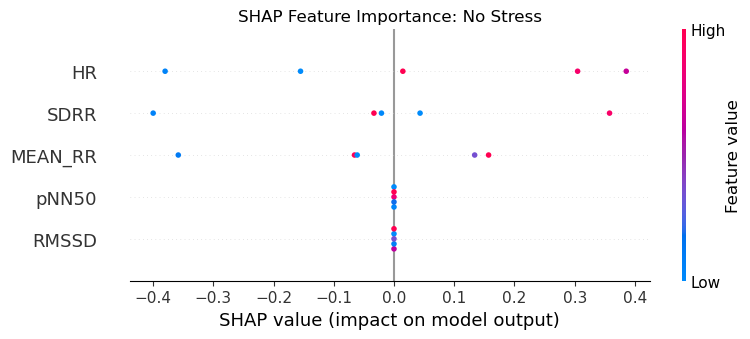

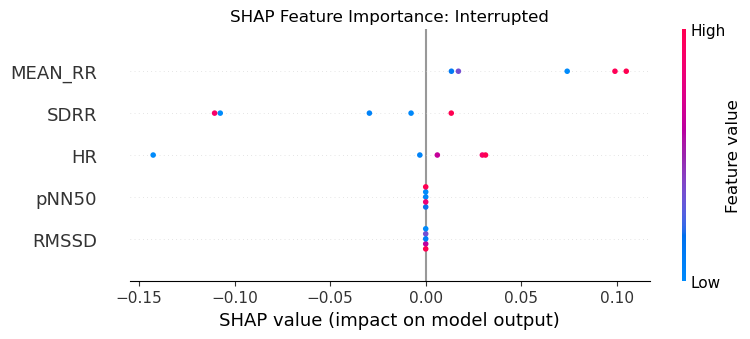

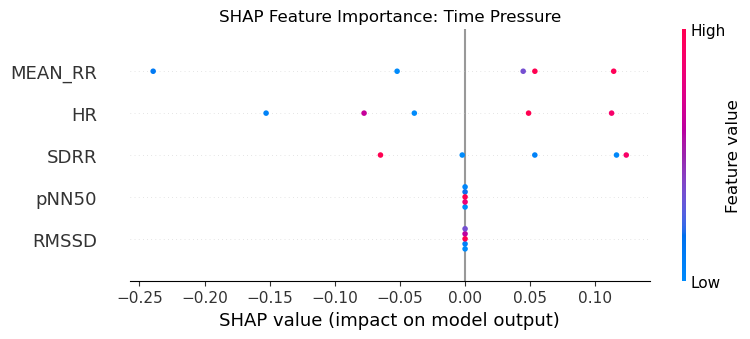

In [21]:
# --- Visualization for All Classes ---
# Prepare averaged background data for plotting (Samples, Features)
avg_data = np.mean(test_samples.numpy(), axis=1) 

for i, class_name in enumerate(CLASSES):
    print(f">>> Processing visualization for class: {class_name}")
    
    # shap_values[i] typically has shape (Samples, TimeSteps, Features) e.g., (5, 30, 5)
    raw_shap = np.array(shap_values[i])
    
    # Collapse the 30-step window to get feature importance per sample
    if len(raw_shap.shape) == 3:
        # If shape is (30, 5, 5) or (30, 5, 3) due to specific explainer behavior
        if raw_shap.shape[0] == WINDOW_SIZE:
             avg_shap = np.mean(raw_shap, axis=0) # Mean across time (axis 0)
        else:
             avg_shap = np.mean(raw_shap, axis=1) # Mean across time (axis 1)
    else:
        avg_shap = raw_shap

    # Final shape check to prevent AssertionError in summary_plot
    if avg_shap.shape != avg_data.shape:
        # Emergency resize/slice if SHAP output indexed classes or features differently
        # (e.g., if it returned (30, 3) instead of (5, 5))
        new_avg_shap = np.zeros(avg_data.shape)
        rows = min(avg_shap.shape[0], avg_data.shape[0])
        cols = min(avg_shap.shape[1], avg_data.shape[1])
        new_avg_shap[:rows, :cols] = avg_shap[:rows, :cols]
        avg_shap = new_avg_shap

    # Create the plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        avg_shap, 
        avg_data, 
        feature_names=FEATURES, 
        show=False
    )
    plt.title(f"SHAP Feature Importance: {class_name}")
    plt.tight_layout()
    
    # Save individual class plots
    filename = f"shap_summary_{class_name.lower().replace(' ', '_')}.png"
    plt.savefig(filename)
    print(f">>> Saved: {filename}")

print(">>> SUCCESS: SHAP analysis complete for all 3 features/classes.")